In [22]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from prophet import Prophet
from fbprophet import Prophet
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast import GridGenerator
from scalecast.notebook import tune_test_forecast
# import prophet

In [23]:
# read in data
data = pd.read_csv('csv/82000278_Toamnei_CO2_2021_7_SHORT.csv')

In [24]:
# set graph sizes
sns.set(rc={'figure.figsize':(30,15)})

In [25]:
data.head()

,time,latitude,longitude,altitude,co2
0,1625086823,45.651464,25.615426,100,553
1,1625086883,45.651464,25.615426,100,551
2,1625086943,45.651464,25.615426,100,551
3,1625087003,45.651464,25.615426,100,558
4,1625087063,45.651464,25.615426,100,559


In [26]:
# the dataset is in sequential order
data = data.sort_values('time')

In [27]:
# data.drop(['time'],axis=1).describe(include='all').T

In [28]:
#Let’s load the series we want to predict, Unique Visits, into a Forecaster object:
f = Forecaster(y=data['co2'],current_dates=data['time'])
f

Forecaster(
    DateStartActuals=1970-01-01T00:00:01.625086823
    DateEndActuals=1970-01-01T00:00:01.625716673
    Freq=None
    N_actuals=10499
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [29]:
#This shows we have 2,167 daily observations from 9/14/2014 through 8/19/2020 to forecast with.
#The first thing we should do after initializing the object is set its test length. We can choose a number of observations to use by passing an int to the function below,
#or split the data fractionally by passing a float between 0 and 1.
f.set_test_length(.2)

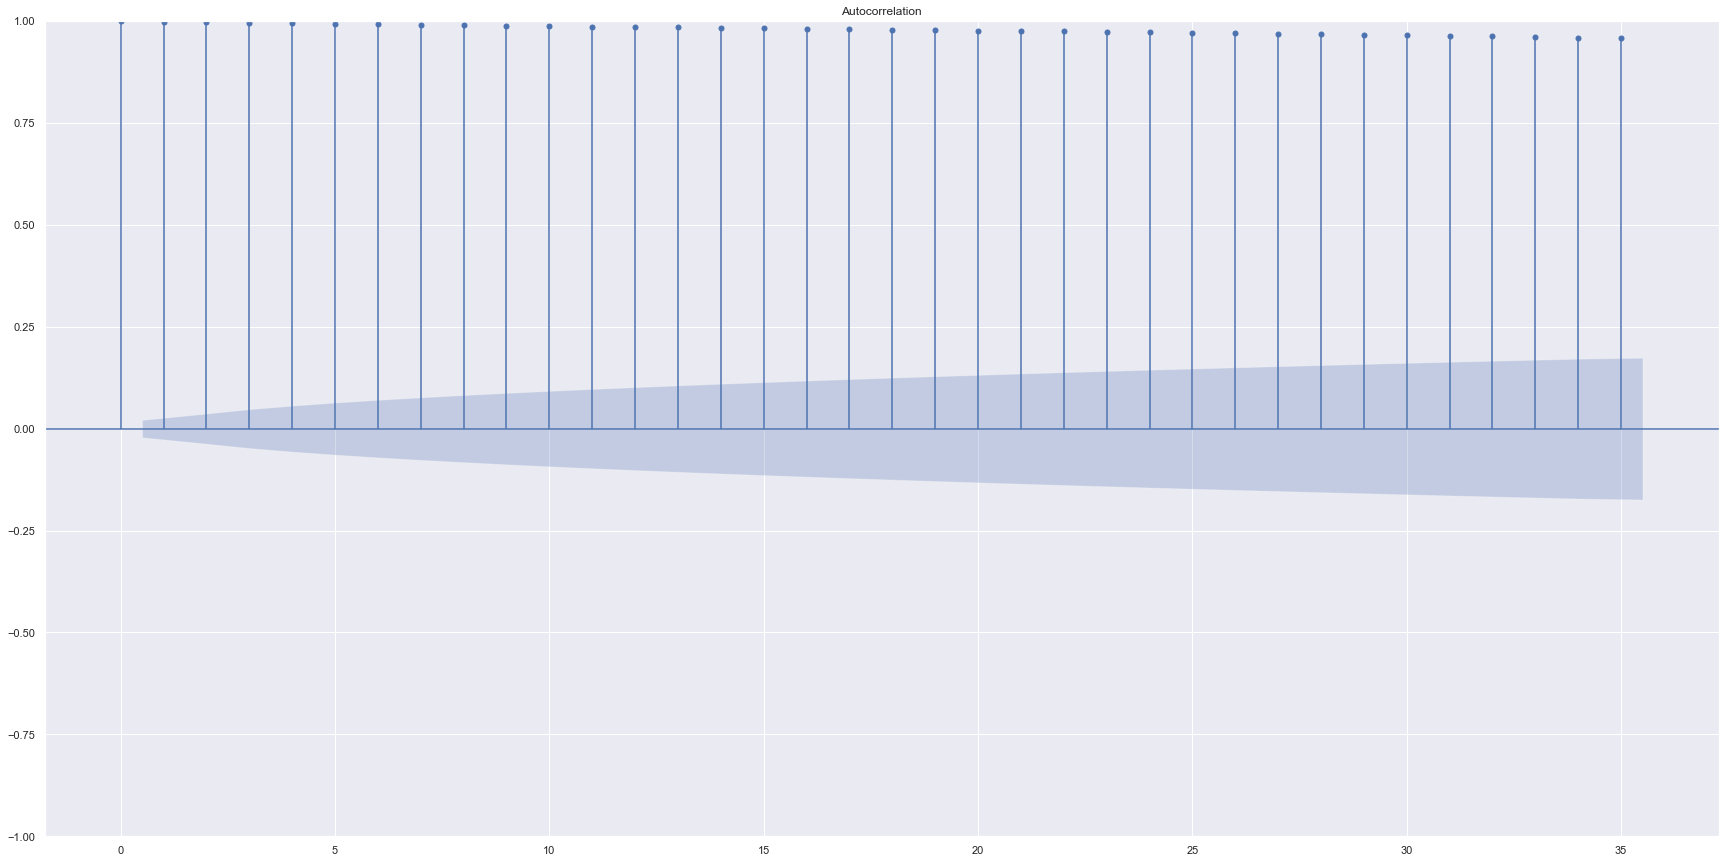

In [30]:
#Before beginning the forecasting process, we should get a better idea of the signals within the time series itself. 
#Using ACF, PACF, and Periodogram plots, we can observe how the series is auto-correlated. We can leave the test set out of all visualizations (train_only=True) 
#to not leak data when making decisions about which signals exist in the data.
f.plot_acf(train_only=True,lags=35)
plt.show()

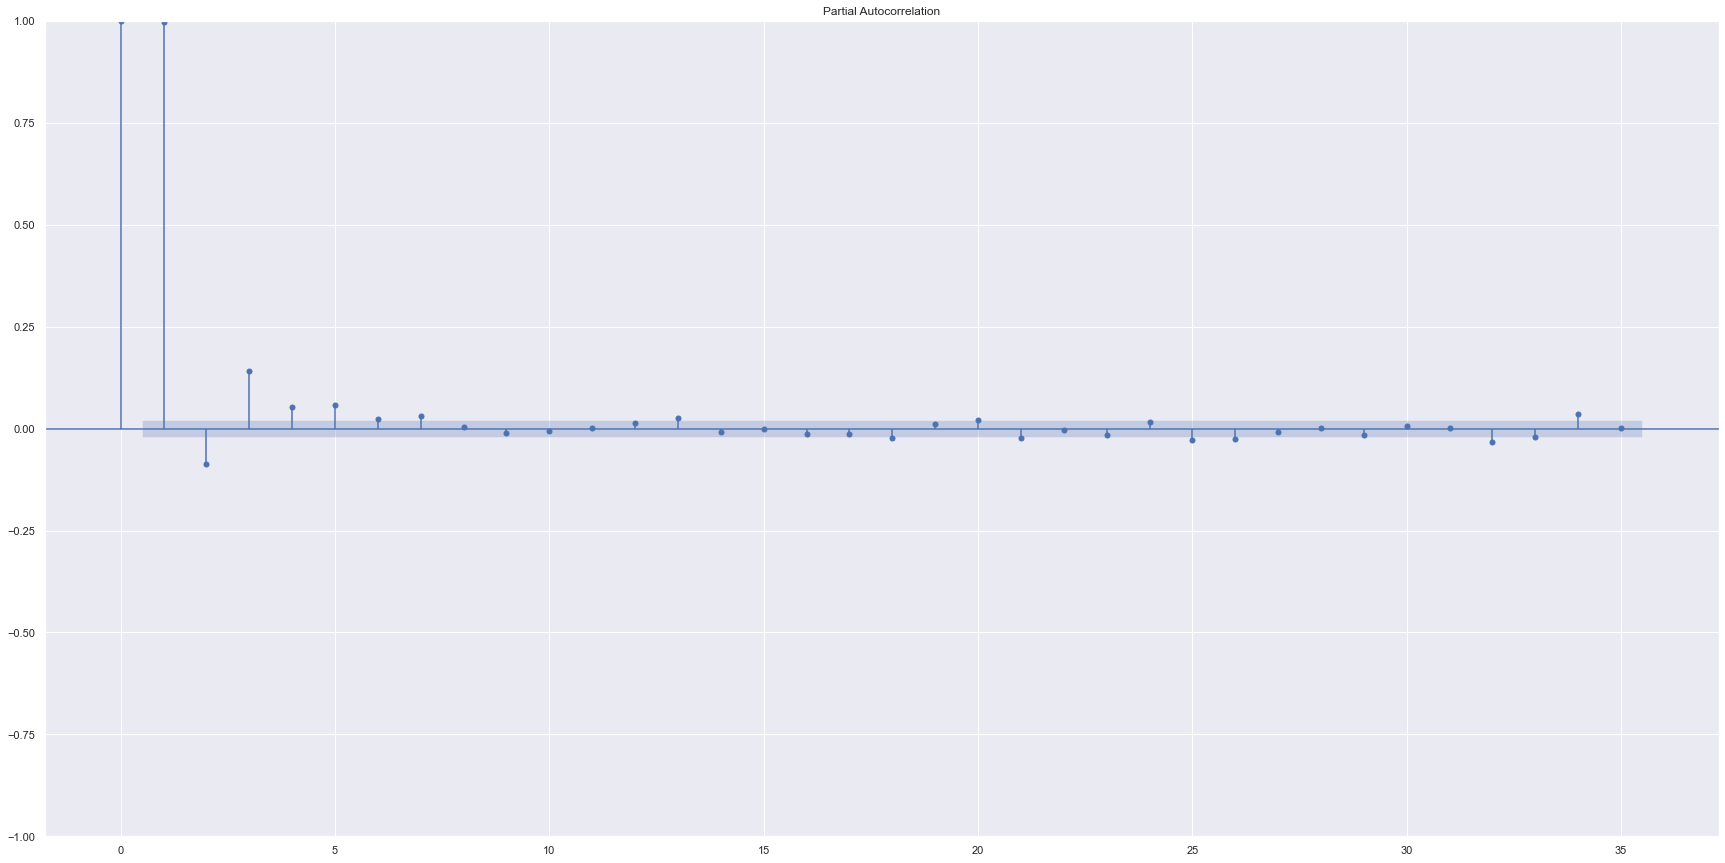

In [31]:
f.plot_pacf(train_only=True,lags=35)
plt.show()

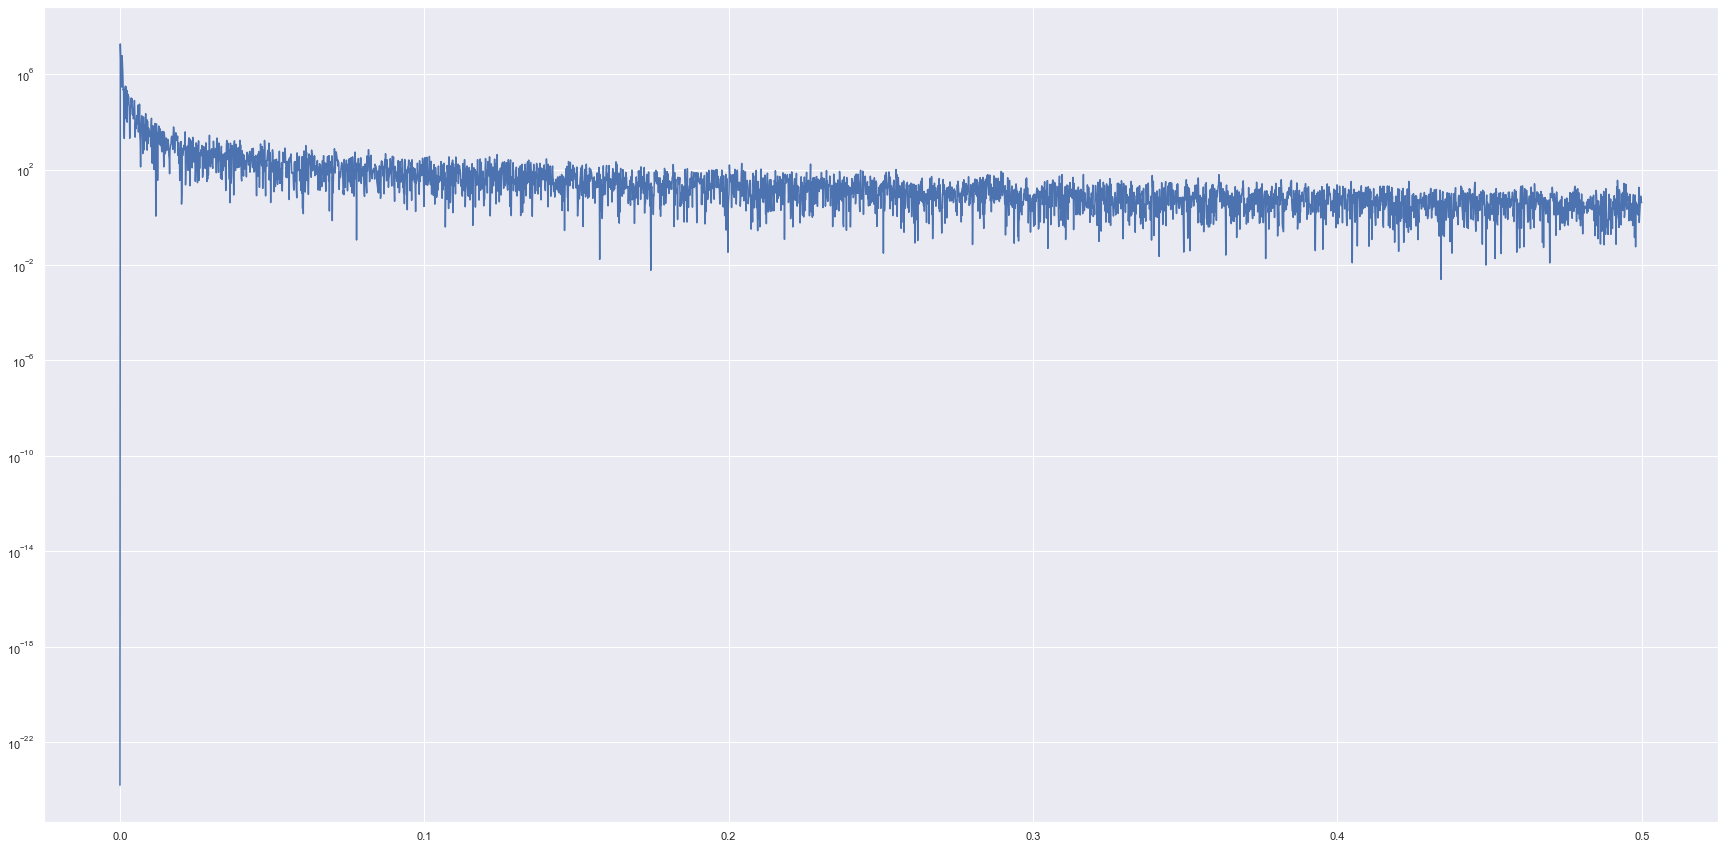

In [32]:
a, b = f.plot_periodogram(train_only=True)
plt.semilogy(a, b)
plt.show()

In [33]:
#There might be some drift in the data.
# f.seasonal_decompose(train_only=True).plot()
# plt.show()

In [34]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -1.92
the p-value is 0.3236
the series is not stationary
----------------------------------------------------------------------------------------------------


In [35]:
f.generate_future_dates(60) # forecast horizon
f.set_validation_length(60) # validation set length for tuning hyperparameters
f.add_ar_terms(7) # 7 dep variable lags
f.add_AR_terms((5,7)) # 5 weekly seasonaly dep variable lags
f.add_seasonal_regressors(
    'month',
    'quarter',
    'week',
    'dayofyear',
    raw=False,
    sincos=True) # wave-form seasonality
f.add_seasonal_regressors(
    'dayofweek',
    'week',
    raw=False,
    dummy=True,
    drop_first=True
) # dummy variable seasonality
f.add_seasonal_regressors('year') # yearly trend
f

Forecaster(
    DateStartActuals=1970-01-01T00:00:01.625086823
    DateEndActuals=1970-01-01T00:00:01.625716673
    Freq=None
    N_actuals=10499
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR21', 'AR28', 'AR35', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'year']
    Differenced=0
    TestLength=2099
    ValidationLength=60
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [36]:
f.set_estimator('prophet')
f.manual_forecast()

ValueError: lam value too large

In [ ]:
f.plot_test_set(ci=True,models='prophet')
plt.show()